# Experimenting to fix cracks & folds in basil  
Using the Optimizer to fix cracks & folds in basil

In [12]:
!mkdir -p ~/.cloudvolume/secrets
!cp /notebooks/*.json ~/.cloudvolume/secrets/
!pip install cloud-volume
!pip install scikit-image

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |################################| 35.5MB 37kB/s  eta 0:00:01
    100% |################################| 5.7MB 259kB/s eta 0:00:01
    100% |################################| 1.6MB 979kB/s eta 0:00:01
  Running setup.py bdist_wheel for networkx ... done
  Stored in directory: /root/.cache/pip/wheels/44/c0/34/6f98693a554301bdb405f8d65d95bbcd3e50180cbfdd98a94e
Successfully built networkx
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [25]:
from cloudvolume import CloudVolume
from cloudvolume.lib import Bbox
import numpy as np
import torch
from torch.autograd import Variable
from optimize import Optimizer
from copy import deepcopy
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
img_mip = 2
mask_mip = 5
src = CloudVolume("gs://neuroglancer/basil_v0/son_of_alignment/v3.04/unmasked", mip=img_mip, 
                                                                parallel=2, fill_missing=True)
cracks = CloudVolume("gs://neuroglancer/basil_v0/son_of_alignment/v3.04/mask/crack_detector_v3", mip=mask_mip,
                                                                 parallel=2, fill_missing=True)
folds = CloudVolume("gs://neuroglancer/basil_v0/son_of_alignment/v3.04/mask/fold_detector_v1", mip=mask_mip,
                                                                 parallel=2, fill_missing=True)

In [7]:
flow = Optimizer(ndownsamples=5, currn=5, avgn=20, lambda1=0.5, lr=0.1, eps=0.001, min_iter=100, max_iter=5000)

In [55]:
full_offset = np.array([102716, 107077, 526])
full_size = np.array([2048, 2048, 1])
full_bbox = Bbox(full_offset, full_offset+full_size)
src_bbox = Bbox.from_slices(src.slices_from_global_coords(full_bbox))
dst_bbox = src_bbox + [0,0,1]
mask_bbox = Bbox.from_slices(folds.slices_from_global_coords(full_bbox))
print(src_bbox)
print(dst_bbox)
print(mask_bbox)

Bbox([25679, 26769, 526],[26191, 27281, 527])
Bbox([25679, 26769, 527],[26191, 27281, 528])
Bbox([3209, 3346, 526],[3273, 3410, 527])


In [60]:
dst = CloudVolume("gs://neuroglancer/basil_v0/son_of_alignment/v3.04/optimizer_tests/v01_no_mask", mip=img_mip, 
                        info=src.info, parallel=False, fill_missing=True, non_aligned_writes=True, cdn_cache=False)
dst.commit_info();

In [61]:
dst[dst_bbox.to_slices()] = src[dst_bbox.to_slices()]

Downloading:   0%|          | 0/2 [00:00<?, ?it/s]

Rechunking image: 0it [00:00, ?it/s]
Uploading: 0it [00:00, ?it/s]
Rechunking image:   0%|          | 0/1 [00:00<?, ?it/s]

Rechunking image:   0%|          | 0/1 [00:00<?, ?it/s]


Rechunking image:   0%|          | 0/1 [00:00<?, ?it/s]



Rechunking image:   0%|          | 0/1 [00:00<?, ?it/s]

Rechunking image: 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


Rechunking image: 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]



In [62]:
src_img = src[src_bbox.to_slices()][:,:,0,0] / 255.0
dst_img = src[dst_bbox.to_slices()][:,:,0,0] / 255.0

fold = folds[mask_bbox.to_slices()][:,:,0,0] / 255.0
crack = cracks[mask_bbox.to_slices()][:,:,0,0] / 255.0
mask = resize(np.minimum(fold, crack), src_bbox.size3()[:2])

Downloading:   0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0/1 [00:00<?, ?it/s]
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


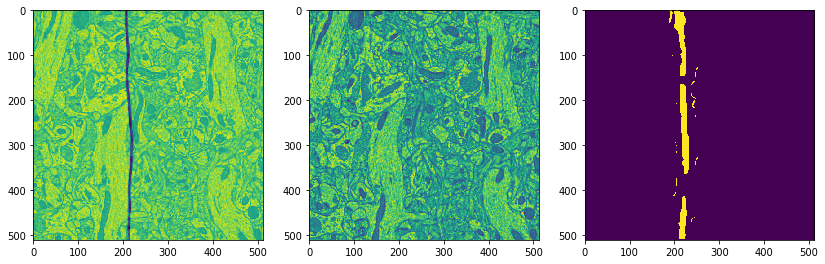

In [97]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,8), facecolor='white')
axes[0].imshow(src_img)
axes[1].imshow(dst_img)
axes[2].imshow(((mask > 3/255.0) & (mask < 6/255.0)).astype(np.float64))
plt.show()

In [101]:
field = flow.process(src_img, dst_img, mask=((mask < 3/255.0) | (mask > 6/255.0)).astype(np.float64))
pred = flow.render(src_img, field)
dst[src_bbox.to_slices()] = (pred[0,0,:,:,np.newaxis, np.newaxis]*255).astype(np.uint8)

(512, 512) (512, 512)
4
[0.2002129]
[0.18596391]
[0.17317581]
[0.16232125]
[0.15285698]
[0.14460933]
[0.13737734]
[0.13097376]
[0.12530488]
[0.12025782]
[0.11579891]
[0.11170506]
[0.10816658]
[0.10481203]
[0.10197292]
[0.09923593]
[0.09684944]
[0.09463312]
[0.09264687]
[0.09080656]
[0.08912484]
[0.08755957]
[0.08618186]
[0.08488783]
[0.08363546]
[0.0825699]
[0.08149608]
[0.08066372]
[0.07975472]
[0.07900774]
[0.07829182]
[0.07758118]
[0.07693526]
[0.07635115]
[0.07577753]
[0.07522465]
[0.07476906]
[0.07420127]
[0.07384073]
[0.07335334]
[0.07299194]
[0.07254787]
[0.07224052]
[0.07186023]
[0.07153086]
[0.07119355]
[0.07090932]
[0.07061712]
[0.0703194]
[0.07008235]
[0.06975469]
[0.06959814]
[0.06929485]
[0.06908429]
[0.06886281]
[0.0686623]
[0.0684109]
[0.06824333]
[0.06804042]
[0.06785181]
[0.06769427]
[0.06748022]
[0.06739085]
[0.06716711]
[0.0670648]
[0.0668681]
[0.06674052]
[0.066602]
[0.06646512]
[0.06628973]
[0.06620151]
[0.0660757]
[0.06589444]
[0.06582858]
[0.06568248]
[0.06558595

[0.05469587]
[0.05468156]
[0.05466923]
[0.05473075]
[0.05465148]
[0.05468085]
[0.05469417]
[0.05465583]
[0.05470191]
[0.05463993]
[0.05468944]
[0.05467872]
[0.0546423]
[0.05466539]
[0.05465215]
[0.05466179]
[0.05461898]
[0.05467981]
[0.05462407]
[0.05464431]
[0.05463625]
[0.05462699]
[0.0546562]
[0.05459809]
[0.05463691]
[0.05463546]
[0.05460308]
[0.05463281]
[0.05459823]
[0.05461349]
[0.05462142]
[0.05461537]
[0.0545841]
[0.05461605]
[0.05461201]
[0.05456694]
[0.05461985]
[0.05459416]
[0.05459028]
[0.05458881]
[0.054565]
[0.05462048]
[0.05456533]
[0.05456947]
[0.05460459]
[0.05456872]
[0.05456712]
[0.05456632]
[0.05459116]
[0.05456502]
[0.05455848]
[0.05455383]
[0.05457694]
[0.05457731]
[0.05451369]
[0.05460586]
[0.0545522]
[0.05452579]
[0.05456969]
[0.05453665]
[0.05456941]
[0.05453277]
[0.05454326]
[0.05456098]
[0.05451902]
[0.05454412]
[0.05453471]
[0.05454932]
[0.05452767]
[0.05453632]
[0.05452744]
[0.054522]
[0.05455556]
[0.05447411]
[0.05456361]
[0.05452529]
[0.05450015]
[0.0545

[0.13348821]
[0.13346347]
[0.13344899]
[0.13342743]
[0.13337488]
[0.133367]
[0.13336834]
[0.13338758]
[0.13336894]
[0.13335861]
[0.13330637]
[0.13329744]
[0.13327949]
[0.13328348]
[0.13329437]
[0.13328515]
[0.13323443]
[0.13321896]
[0.13321318]
[0.13321719]
[0.13319951]
[0.13322431]
[0.13318819]
[0.13316147]
[0.13315758]
[0.13314049]
[0.1331114]
[0.133149]
[0.13313976]
[0.13310361]
[0.1330956]
[0.13306385]
[0.13305202]
[0.1330453]
[0.13309976]
[0.1330211]
[0.13304648]
[0.13301146]
[0.13298045]
[0.13299948]
[0.13299093]
[0.13299122]
[0.1329437]
[0.13295558]
[0.13285986]
[0.1328704]
[0.13286766]
[0.13278818]
[0.13285857]
[0.13281634]
[0.13277188]
[0.13273904]
[0.13278313]
[0.13271055]
[0.13275692]
[0.13273814]
[0.13268858]
[0.13270037]
[0.1326703]
[0.13268135]
[0.13265899]
[0.13268031]
[0.13262609]
[0.13264525]
[0.1326359]
[0.13260284]
[0.13265203]
[0.13258378]
[0.13259037]
[0.13261162]
[0.13259512]
[0.13254106]
[0.13259779]
[0.13255689]
[0.13250491]
[0.13256761]
[0.13254434]
[0.13249499

[0.2794717]
[0.27944678]
[0.2794977]
[0.2793973]
[0.2793885]
[0.27936584]
[0.27933043]
[0.27930927]
[0.2792919]
[0.27929166]
[0.27928096]
[0.27924967]
[0.2792207]
[0.27917698]
[0.279171]
[0.27915087]
[0.27909148]
[0.27914]
[0.27910203]
[0.27907616]
[0.27904958]
[0.27900863]
[0.27900597]
[0.27899823]
[0.27894813]
[0.27895576]
[0.27899075]
[0.278966]
[0.27888936]
[0.27890694]
[0.2789162]
[0.27888134]
[0.27886355]
[0.27880427]
[0.27882496]
[0.27883947]
[0.27880466]
[0.27876797]
[0.27877817]
[0.27880895]
[0.27878684]
[0.2787642]
[0.27869517]
[0.2786906]
[0.27869207]
[0.27869144]
[0.27866602]
[0.2786306]
[0.2786157]
[0.27861005]
[0.2786245]
[0.27854803]
[0.27855408]
[0.27860683]
[0.27857816]
[0.278542]
[0.2785251]
[0.27851853]
[0.27851218]
[0.27848548]
[0.27847335]
[0.27848047]
[0.27852154]
[0.27848232]
[0.2784144]
[0.27840868]
[0.27841306]
[0.27842212]
[0.27841517]
[0.2783894]
[0.27836478]
[0.2784013]
[0.27839816]
[0.27831542]
[0.27835763]
[0.27831537]
[0.2783516]
[0.27834275]
[0.27828905]

Rechunking image: 0it [00:00, ?it/s]
Uploading: 0it [00:00, ?it/s]
Rechunking image:   0%|          | 0/1 [00:00<?, ?it/s]

Rechunking image:   0%|          | 0/1 [00:00<?, ?it/s]


Rechunking image:   0%|          | 0/1 [00:00<?, ?it/s]



Rechunking image:   0%|          | 0/1 [00:00<?, ?it/s]

[0.9009563]
[0.9009745]
[0.90088856]
[0.9009417]
[0.9006899]
[0.9006386]
[0.90072167]
[0.9006729]
done: 2698
torch.Size([1, 512, 512, 2])



Rechunking image: 100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


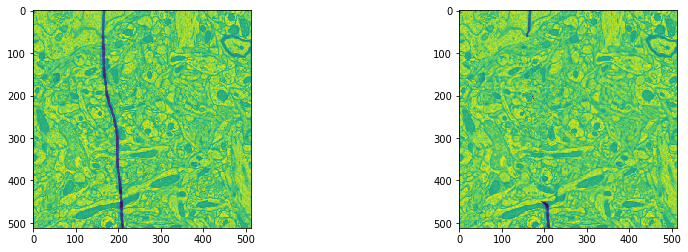

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,4), facecolor='white')
axes[0].imshow(src_img)
axes[1].imshow(pred[0,0])
plt.show()